# Лабораторная работа №4. Яровенко Максим ИУ5Ц-82Б.
# Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
data = pd.read_csv('WineQT.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [3]:
# Корреляция с качеством по модулю - top
best_params = data.corr()['quality'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.35]
best_params

alcohol             0.484866
volatile acidity    0.407394
Name: quality, dtype: float64

# Разделение выборки на обучающую и тестовую

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data[best_params.index], data['quality'], test_size=0.3, random_state=3)

# Обучение моделей

## 1) Линейная регрессия

In [5]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.3759245136929015
MSE: 0.43532353746549773
MAE: 0.5173943056976588


## 2) Полиномиальная регрессия

In [6]:
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: 0.3792845965115883
MSE: 0.4329797134075087
MAE: 0.5137914217980332


## 3) SVM

In [7]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,alcohol,volatile acidity
count,8.000000e+02,8.000000e+02
mean,-1.268985e-15,-3.941292e-16
std,1.000626e+00,1.000626e+00
min,-1.874780e+00,-2.333061e+00
25%,-8.571453e-01,-7.623067e-01
50%,-3.020718e-01,-3.302791e-02
75%,6.230507e-01,5.910664e-01
max,4.138516e+00,5.857301e+00


In [8]:
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 0.1}


In [9]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=11)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.38227831957930203
MSE: 0.43089144340712626
MAE: 0.5051303120345857


## 4) Дерево решений

In [10]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 25}


In [11]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.3466740764242058
MSE: 0.45572716507723077
MAE: 0.5209824447697117


# Важность признаков в дереве решений

In [12]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

alcohol: 0.642
volatile acidity: 0.358


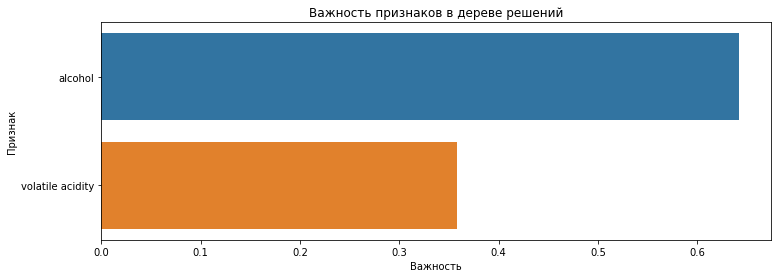

In [13]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

# Сравнение моделей

In [14]:
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.3759245136929015
MSE: 0.43532353746549773
MAE: 0.5173943056976588

Полиномиальная регрессия
R^2: 0.3792845965115883
MSE: 0.4329797134075087
MAE: 0.5137914217980332

Метод опорных векторов
R^2: 0.38227831957930203
MSE: 0.43089144340712626
MAE: 0.5051303120345857

Дерево решений
R^2: 0.3466740764242058
MSE: 0.45572716507723077
MAE: 0.5209824447697117
